In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud, ImageColorGenerator
from plotly.offline import iplot
import warnings
warnings.filterwarnings("ignore")

import nltk
import re
import string
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

plt.rcParams['figure.figsize'] = 8, 5
plt.style.use("fivethirtyeight")
pd.options.plotting.backend = "plotly"

data = pd.read_csv('../input/covid19-tweets/covid19_tweets.csv')

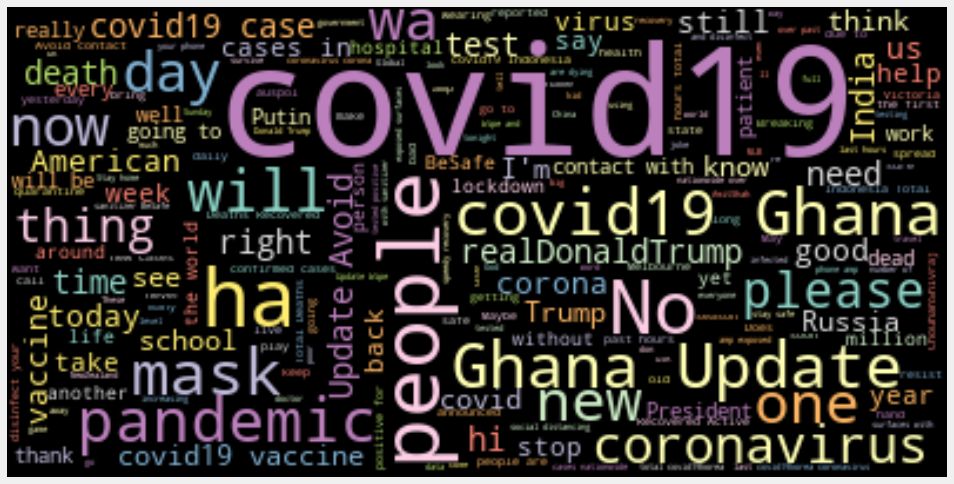

In [2]:
text = ",".join(review for review in data.text if 'COVID' not in review and 'https' not in review and 'Covid' not in review)
wordcloud = WordCloud(max_words=200, colormap='Set3',background_color="black").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.figure(1,figsize=(12, 12))
plt.show()

# A small look at the Data

In [3]:
data.head(3)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False


# Some quick questions from the data

In [4]:
print('How many posts are made with #covid19? -> {}\n'.format(data.shape[0]))
print('How many unique users have posted? -> {}\n'.format(data.user_name.nunique()))
print('How many unique locations were the posts made from? -> {}\n'.format(data.user_location.nunique()))
print('How many users have more than 1 million followers(higher chances of spread)? -> {}\n'.format(data[data['user_followers']>1000000].user_name.nunique()))
print('How many users are verified(denoting a known person)? -> {}\n'.format(data[data['user_verified']==True].user_name.nunique()))
print('How many tweets are re-tweets? -> {}'.format(data[data['is_retweet']==True].shape[0]))

How many posts are made with #covid19? -> 110101

How many unique users have posted? -> 63553

How many unique locations were the posts made from? -> 19626

How many users have more than 1 million followers(higher chances of spread)? -> 141

How many users are verified(denoting a known person)? -> 4729

How many tweets are re-tweets? -> 0


<p style='font-size:18px;'>Ahead in the notebook I will work on proving each of these questions with the help of appropriate visualizations.</p>

# Description of data

In [5]:
data.describe()

,user_followers,user_friends,user_favourites
count,1.101010e+05,110101.000000,1.101010e+05
mean,1.042786e+05,2139.686878,1.479522e+04
std,8.252360e+05,9370.897851,4.544362e+04
min,0.000000e+00,0.000000,0.000000e+00
25%,1.720000e+02,155.000000,2.200000e+02
50%,9.890000e+02,553.000000,1.863000e+03
75%,5.244000e+03,1748.000000,9.719000e+03
max,4.944256e+07,497363.000000,2.047197e+06


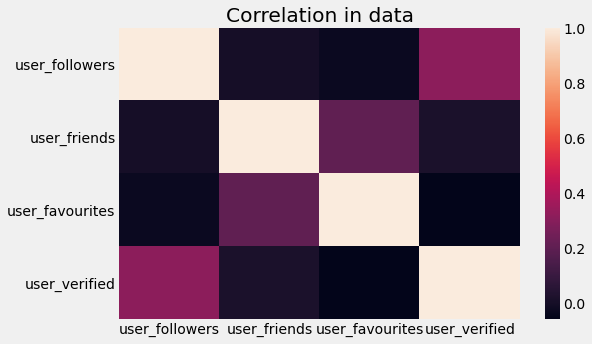

In [6]:
sns.heatmap(data.drop('is_retweet', axis=1).corr())
plt.title('Correlation in data')
plt.show()

# Missing values in the data

In [7]:
fig = data.isnull().sum().reset_index().plot(kind='bar', x=0, y='index', color=0)
fig.update_layout(title='Mising Values Plot', xaxis_title='Count', yaxis_title='Column Names')
fig.show()

<p style='font-size:16px'>In the description of this dataset it was mentioned tht the tweets crawled have a hashtag of covid19 and so it can be considered that the missing values in the hashtag column contain #covid19 by default<br><br>
The user location and user description won't be contributing much to the sentiment of the tweets either. So there is no such need to fix them.</p>

# Distributions of the data

In [8]:
fig = px.box(data, y="user_followers", color="user_verified",
                   title="User Followers Distribution")
fig.show()

<p style='font-size:18px'>The above box plot is not much interpretable to get information from them about the distribution, so let's plot a kdeplot and check the distribution.</p>

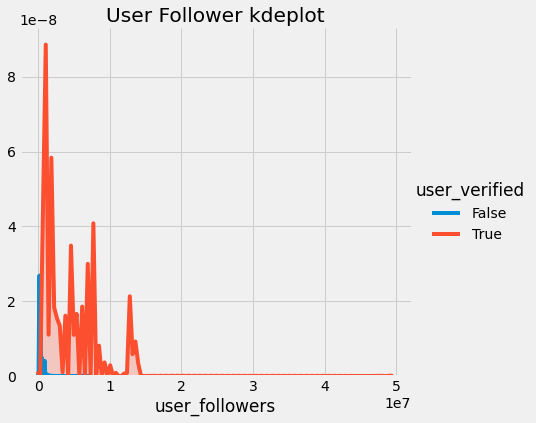

In [9]:
sns.FacetGrid(data, hue="user_verified", height=6,).map(sns.kdeplot, "user_followers" ,shade=True).add_legend()
plt.title('User Follower kdeplot')
plt.show()

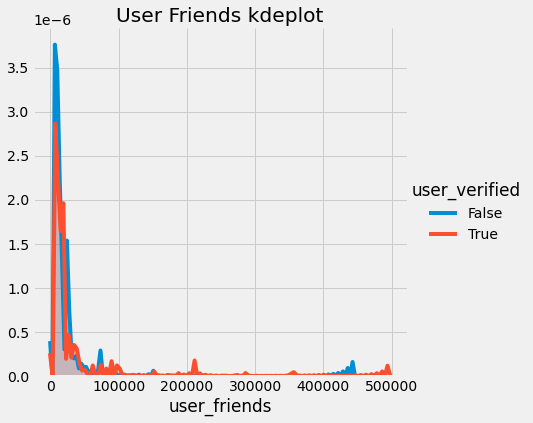

In [10]:
sns.FacetGrid(data, hue="user_verified", height=6,).map(sns.kdeplot, "user_friends" ,shade=True).add_legend()
plt.title('User Friends kdeplot')
plt.show()

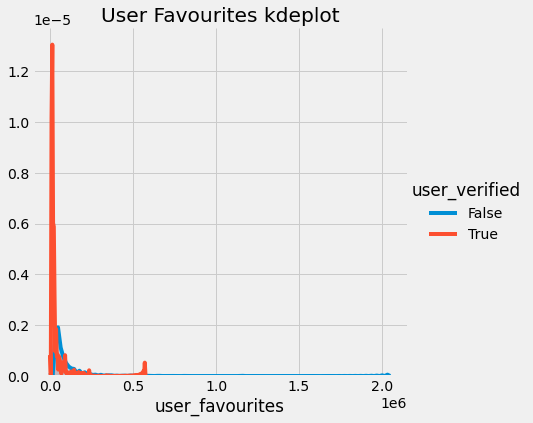

In [11]:
sns.FacetGrid(data, hue="user_verified", height=6,).map(sns.kdeplot, "user_favourites" ,shade=True).add_legend()
plt.title('User Favourites kdeplot')
plt.show()

<p style='font-size:18px'>All the above variables show a highly skewed distribution and this can be expected since it is twitter data and the number of users with a known personality and high number of followers will be much lesser.</p>

In [12]:
fig = data.source.value_counts().reset_index().head(10).plot(kind='bar',x='index',y='source',color='source')
fig.update_layout(title='Top 10 sources of tweets', xaxis_title='Sources', yaxis_title='')
fig.show()

In [13]:
data['text_length'] = data['text'].str.len()
fig = px.violin(data, y="text_length", color="user_verified",
                   title="Text Length Distribution")
fig.show()

In [14]:
fig = data.user_location.value_counts().reset_index().head(10).plot(kind='bar',x='index',y='user_location',color='user_location')
fig.update_layout(title='Top 10 location of tweets', xaxis_title='Locations', yaxis_title='')
fig.show()

In [15]:
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

#Source: https://www.kaggle.com/tamilsel/exploring-covid-19-tweets-and-sentiment-analysis

def text_preprocessing(text):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    combined_text = ' '.join(tokenized_text)
    return combined_text

data['text'] = data['text'].apply(text_preprocessing)

In [16]:
data['hashtag_count'] = data['hashtags'].str.split(',').str.len()
data['hashtag_count'] = data['hashtag_count'].fillna(0.0)
fig = data.hashtag_count.value_counts().reset_index().head(7).plot(kind='bar', x='index', y='hashtag_count', color='hashtag_count')
fig.update_layout(title='Hashtag Count Distribution', xaxis_title='Hashtag Counts', yaxis_title='')
fig.show()

# Exploring the text data

In [17]:
fig = data['text'].str.split().str.len().plot(kind='hist')
fig.update_layout(title='Word Count Distribution', xaxis_title='Word Count', yaxis_title='')
fig.show()

In [18]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(data['text'], 15)
    
df1 = pd.DataFrame(common_words, columns = ['text' , 'count'])
fig = df1.plot(kind='bar', x='text', y='count', color='count')
fig.update_layout(yaxis_title='Count', title='Top 15 words before removing stop words')
fig.show()

In [19]:
#Source: https://www.kdnuggets.com/2019/05/complete-exploratory-data-analysis-visualization-text-data.html

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(data['text'], 15)
    
df1 = pd.DataFrame(common_words, columns = ['text' , 'count'])
fig = df1.plot(kind='bar', x='text', y='count', color='count')
fig.update_layout(yaxis_title='Count', title='Top 15 words after removing stop words')
fig.show()

In [20]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(data['text'], 20)

df1 = pd.DataFrame(common_words, columns = ['text' , 'count'])
fig = df1.plot(kind='bar', y='text', x='count', color='count')
fig.update_layout(yaxis_title='Count', title='Top 20 bigrams before removing stop words')
fig.show()

In [21]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(data['text'], 20)

df1 = pd.DataFrame(common_words, columns = ['text' , 'count'])
fig = df1.plot(kind='bar', y='text', x='count', color='count')
fig.update_layout(yaxis_title='Count', title='Top 20 bigrams after removing stop words')
fig.show()

In [22]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_trigram(data['text'], 15)

df1 = pd.DataFrame(common_words, columns = ['text' , 'count'])
fig = df1.plot(kind='bar', y='text', x='count', color='count')
fig.update_layout(yaxis_title='Count', title='Top 15 trigrams before removing stop words')
fig.show()

In [23]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_trigram(data['text'], 15)

df1 = pd.DataFrame(common_words, columns = ['text' , 'count'])
fig = df1.plot(kind='bar', y='text', x='count', color='count')
fig.update_layout(yaxis_title='Count', title='Top 15 trigrams after removing stop words')
fig.show()

In the next version I will be adding the sentiment analysis on the text data.